## Clustering - DBSCAN
- Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.
- Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.
- Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [1]:
# from __future__ import division
import itertools

# To get rid of those blocks of red warnings
import warnings
warnings.filterwarnings("ignore")

# Standard Imports
import numpy as np
from scipy import stats
import pandas as pd
from math import sqrt
import os
from scipy.stats import spearmanr
from sklearn import metrics
from random import randint

# Vis Imports
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import plotly.express as px
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

# Modeling Imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import sklearn.preprocessing
import statsmodels.api as sm
from sklearn.cluster import DBSCAN

# Custom Module Imports
import env

In [6]:
def get_db_url(database, env):
    return f'mysql+pymysql://{env.user}:{env.password}@{env.host}/{database}'

In [8]:
url = get_db_url("grocery_db", env)

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [9]:
# Cluster on all or a selected subset of features
grocery_milk_fresh = df[["Grocery", "Milk", "Fresh"]]
grocery_milk_fresh.head(2)

,Grocery,Milk,Fresh
customer_id,,,
0,7561,9656,12669
1,9568,9810,7057


In [10]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(grocery_milk_fresh)

# Use the scaler
grocery_milk_fresh = scaler.transform(grocery_milk_fresh)
grocery_milk_fresh

array([[0.08146416, 0.13072723, 0.11294004],
       [0.10309667, 0.13282409, 0.06289903],
       [0.08278992, 0.11918086, 0.05662161],
       ...,
       [0.32594285, 0.21013575, 0.1295431 ],
       [0.02402535, 0.02622442, 0.091727  ],
       [0.02702178, 0.02237109, 0.02482434]])

In [11]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(grocery_milk_fresh)

DBSCAN(eps=0.1, min_samples=20)

In [12]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["Grocery", "Milk", "Fresh"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(grocery_milk_fresh, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626


In [13]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()

 0    409
-1     31
Name: labels, dtype: int64

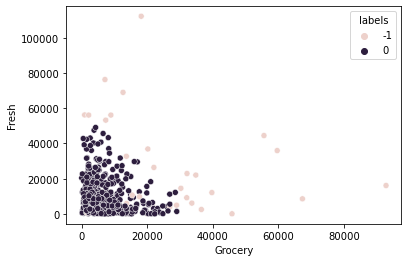

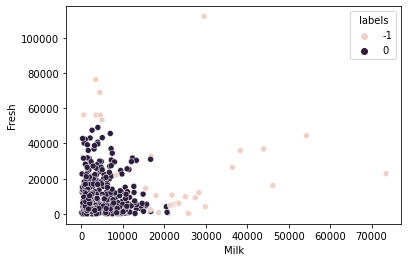

In [14]:
sns.scatterplot(df.Grocery, df.Fresh, hue=df.labels)
plt.show()

sns.scatterplot(df.Milk, df.Fresh, hue=df.labels)
plt.show()

Text(0.5, 0, 'Grocery')

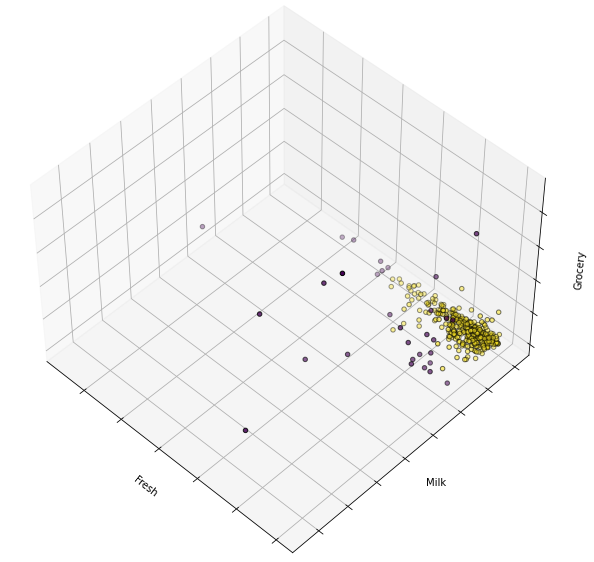

In [15]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Milk, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

### Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [29]:
def acquire():
    """
    This function acquires the data from the codeup database
    and save it into a dataframe.
    """
    url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
    query = '''
    SELECT date,
           path as page,
           user_id,
           cohort_id as cohort,
           ip
    FROM logs;
    '''
    df0 = pd.read_sql(query, url)
    df = df0.copy()
    return df

In [30]:
df = acquire()

In [31]:
df.head()

,date,page,user_id,cohort,ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [33]:
# lets do a little aggregation based on the student id's in the data set,
# focusing on the number of unique hits
id_counts = df.groupby(['user_id'])['date', 'page', 'cohort'].nunique()

In [34]:
# my index is the user id
# and my aggregated columns represent the unique
# number of days, pages, and cohorts associated with each
id_counts.head()


,date,page,cohort
user_id,,,
1,637,976,2
2,83,151,1
3,107,169,1
4,54,143,1
5,82,197,1


In [35]:
# let's observe unique hits based on cohort
cohort_counts = df.groupby('cohort')['user_id', 'date','page'].nunique()

In [36]:
# convert our date to a pandas datetime so we can take the minimum
# value
df['date'] = pd.to_datetime(df['date'])

In [37]:
first_access = df.groupby('user_id')['date'].min()
first_access

user_id
1     2018-01-26
2     2018-01-26
3     2018-01-26
4     2018-01-26
5     2018-01-26
         ...    
977   2021-04-12
978   2021-04-12
979   2021-04-12
980   2021-04-13
981   2021-04-19
Name: date, Length: 981, dtype: datetime64[ns]

In [38]:
id_by_first_access_date = pd.DataFrame({'first_access_date': first_access}).reset_index().\
groupby('first_access_date').count()


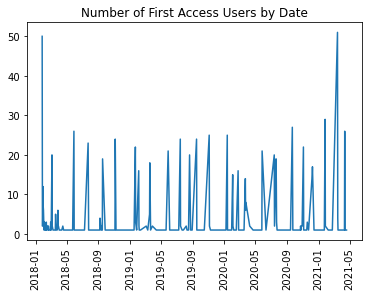

In [39]:
plt.plot(id_by_first_access_date)
plt.xticks(rotation=90)
plt.title('Number of First Access Users by Date')
plt.show()

In [40]:
# let's make an examination:
# we want to look at individual users,
# and I want to know how they interact with pages in the curriculum,
# the number of unique pages and the number of total pages
page_views = df.groupby(['user_id'])['page'].agg(['count', 'nunique'])

In [41]:
page_views

,count,nunique
user_id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197
...,...,...
977,86,12
978,55,18
979,127,20


<AxesSubplot:>

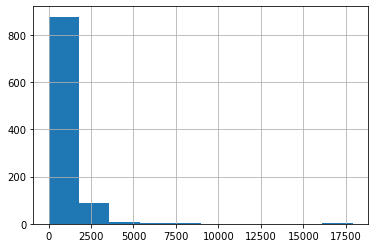

In [42]:
page_views['count'].hist()


In [43]:
# let's narrow down the scope
# if we want to examine the users that have a lower count
# but a high nunique,
# we observed with our value counts and histograms previously
# that we had a range of approxiately 200 for each of those features
# per user
# lets narrow down to users that have less than 200 page view total counts
# but have over 190
page_views[(page_views['count'] < 600) & (page_views['nunique'] > 190)]

,count,nunique
user_id,,
51,592,194
313,270,194


In [44]:
# create the scaler
scaler = MinMaxScaler().fit(page_views)
# use the scaler
scaled_page_views = scaler.transform(page_views)


In [45]:
# whip up some new column names
scaled_cols = [col + '_scaled' for col in page_views.columns]


In [46]:
scaled_page_views_df = pd.DataFrame(scaled_page_views, columns=scaled_cols, index=page_views.index)


In [47]:
# create the object first
dbsc = DBSCAN(min_samples=20, eps=0.1)

In [48]:
# fit the object like we normally would with sklearn
dbsc.fit(scaled_page_views_df)

DBSCAN(eps=0.1, min_samples=20)

In [51]:
dbsc.labels_.shape


(981,)

In [52]:
scaled_page_views_df.shape


(981, 2)

In [49]:
# Merge the scaled and non-scaled values into one dataframe
page_views_total = page_views.merge(
    scaled_page_views_df, on=page_views.index).drop(
    columns=['key_0'])

In [50]:
page_views_total.shape


(981, 4)

In [53]:
page_views_total['labels'] = dbsc.labels_


In [54]:
page_views_total[page_views_total.labels == -1]


,count,nunique,count_scaled,nunique_scaled,labels
0,7404,976,0.413298,1.000000,-1
10,17913,871,1.000000,0.892308,-1
52,12329,333,0.688254,0.340513,-1
63,16347,437,0.912573,0.447179,-1
247,5075,625,0.283274,0.640000,-1
313,7783,225,0.434457,0.229744,-1
494,6451,243,0.360094,0.248205,-1
580,6434,354,0.359145,0.362051,-1


In [55]:
page_views = page_views_total


In [56]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(page_views.describe())
print("-------------")
print("Inliers")
print(page_views[page_views.labels==0].describe())
print("-------------")
print("Outliers")
print(page_views[page_views.labels==-1].describe())

Population
              count     nunique  count_scaled  nunique_scaled      labels
count    981.000000  981.000000    981.000000      981.000000  981.000000
mean     917.657492  118.356779      0.051176        0.120366   -0.008155
std     1208.871322   80.781117      0.067489        0.082852    0.089982
min        1.000000    1.000000      0.000000        0.000000   -1.000000
25%      187.000000   53.000000      0.010384        0.053333    0.000000
50%      692.000000  140.000000      0.038577        0.142564    0.000000
75%     1297.000000  166.000000      0.072354        0.169231    0.000000
max    17913.000000  976.000000      1.000000        1.000000    0.000000
-------------
Inliers
             count     nunique  count_scaled  nunique_scaled  labels
count   973.000000  973.000000    973.000000      973.000000   973.0
mean    843.253854  115.153135      0.047022        0.117080     0.0
std     787.044042   68.765856      0.043939        0.070529     0.0
min       1.000000    1.0

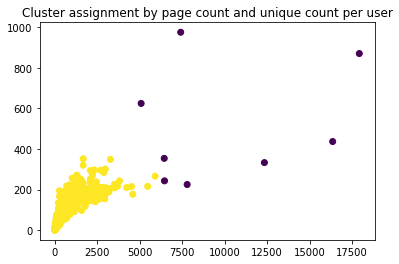

In [57]:
plt.scatter(page_views['count'],
           page_views['nunique'],
           c=page_views['labels'])
plt.title('Cluster assignment by page count and unique count per user')
plt.show()

### Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [4]:
def acquire_zillow():
    '''
    This function checks if the zillow data is saved locally. 
    If it is not local, this function reads the zillow data from 
    the CodeUp MySQL database and return it in a DataFrame.
    '''
    
    # Acquire
    # Set file name
    filename = 'zillow.csv'
    # if the file is saved locally... grab that
    if os.path.isfile(filename):
        df = pd.read_csv(filename).iloc[:,1:]
    # if the file is not local, pull it via SQL from the CodeUp database
    else:
        q = '''SELECT *
                FROM properties_2017
                LEFT JOIN predictions_2017
                    USING (parcelid)
                LEFT JOIN heatingorsystemtype
                    USING (heatingorsystemtypeid)
                LEFT JOIN buildingclasstype
                    USING (buildingclasstypeid)
                LEFT JOIN architecturalstyletype
                    USING (architecturalstyletypeid)
                LEFT JOIN airconditioningtype
                    USING (airconditioningtypeid)
                LEFT JOIN storytype
                    USING (storytypeid)
                LEFT JOIN typeconstructiontype
                    USING (typeconstructiontypeid)
                LEFT JOIN propertylandusetype
                    USING (propertylandusetypeid)
                WHERE transactiondate LIKE '2017%%'
                AND latitude is not NULL
                AND longitude is not NULL
                AND (propertylandusetypeid = 261 OR propertylandusetypeid = 279);
                '''
                
        df = pd.read_sql(q, env.conn('zillow'))
        # only keep the most recent transaction for each home
        df = df.sort_values('transactiondate').drop_duplicates(keep='last')
        # drop the foreign keys and other unnecessary columns
        df = df.drop(columns=['heatingorsystemtypeid', 
                              'buildingclasstypeid',
                              'architecturalstyletypeid', 
                              'airconditioningtypeid',
                              'storytypeid',
                              'typeconstructiontypeid',
                              'propertylandusetypeid',
                              'parcelid',
                              'finishedsquarefeet13',
                              'finishedsquarefeet15',
                              'buildingclassdesc'])
        
        # Save it locally for future use
        df.to_csv(filename)
        df = pd.read_csv(filename).iloc[:,1:]
    # return the file
    return df

In [5]:
def prepare_zillow(df):
    '''
    This function takes in the zillow dataframe after it has been acquired
    from the acquire_zillow function. It drops columns, handles nulls,
    renames features, and feature engineers before returning the complete
    dataframe.
    '''
    # drop foreign key columns or ones that aren't needed
    df = df.drop(columns=['buildingqualitytypeid','propertyzoningdesc','unitcnt','heatingorsystemdesc','id','id.1'])
    
    # fill missing values
    df.fullbathcnt = df.fullbathcnt.fillna(0)
    df.pooltypeid2 = df.pooltypeid2.fillna(0)
    df.pooltypeid10 = df.pooltypeid10.fillna(0)
    df.pooltypeid7 = df.pooltypeid7.fillna(0)
    df.fireplacecnt = df.fireplacecnt.fillna(0)
    df.decktypeid = df.decktypeid.fillna(0)
    df.poolcnt = df.poolcnt.fillna(0)
    df.hashottuborspa = df.hashottuborspa.fillna(0)
    df.typeconstructiondesc = df.typeconstructiondesc.fillna('None')
    df.fireplaceflag = df.fireplaceflag.fillna(0)
    df.threequarterbathnbr = df.threequarterbathnbr.fillna(0)
    df.taxdelinquencyyear = df.taxdelinquencyyear.fillna(99999)
    df.taxdelinquencyflag = df.taxdelinquencyflag.fillna('N')
    df.calculatedbathnbr = df.calculatedbathnbr.fillna(0)
    df.basementsqft = df.basementsqft.fillna(0)
    df.numberofstories.value_counts(dropna=False)
    
    # drop columns or indicies beyond the threshold of nulls
    df = handle_missing_values(df, prop_req_cols=.6, prop_req_rows=.75)
    
    # drop any remaining indicies with nulls
    df = df.dropna()
    # drop the weird zipcode
    df = df.drop(index=df[df.regionidzip == df.regionidzip.max()].index.tolist())
    # rename all the columns
    df.columns = ['basement_sqft', 'baths', 'beds', 'bathnbed', 'decktype', 'area', 'area12', 'county', 'fireplace', 'fullbath', 'hottub_or_spa', 'lat', 'long', 'lotsize',
              'pool', 'pool10', 'pool2', 'pool7', 'landuse_code', 'raw_census', 'city_id', 'county_id', 'zip_id', 'rooms', 'threequarterbnb', 'year_built',
               'fireplace_flag', 'structure_value', 'tax_value', 'assessment_year', 'land_value', 'taxes', 'tax_delq_flag', 'tax_delq_year', 'census', 'logerror',
               'transactiondate', 'construction_type', 'landuse_desc']
    # do some feature engineering
    df['living_space'] = df.area - df.baths*60 - df.beds*200
    df['price_sqft'] = df.tax_value/df.area
    
    return df

In [6]:
df = acquire_zillow()

In [8]:
def handle_missing_values(df, prop_req_cols=0.5, prop_req_rows=0.75):
    '''
    This function takes in a dataframe and drops columns with more than 50%
    missing values and rows with more than 75% missing values before returning
    the DataFrame. 
    '''
    threshold = int(round(prop_req_cols * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_req_rows * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold)
    
    return df

In [9]:
df = prepare_zillow(df)

In [10]:
df.head()

,basement_sqft,baths,beds,bathnbed,decktype,area,area12,county,fireplace,fullbath,...,taxes,tax_delq_flag,tax_delq_year,census,logerror,transactiondate,construction_type,landuse_desc,living_space,price_sqft
0,0.0,3.5,4.0,3.5,0.0,3100.0,3100.0,6059.0,0.0,3.0,...,11013.72,N,99999.0,6.059063e+13,0.025595,2017-01-01,None,Single Family Residential,2090.0,330.090968
1,0.0,1.0,2.0,1.0,0.0,1465.0,1465.0,6111.0,1.0,1.0,...,5672.48,N,99999.0,6.111001e+13,0.055619,2017-01-01,None,Single Family Residential,1005.0,316.723549
2,0.0,2.0,3.0,2.0,0.0,1243.0,1243.0,6059.0,0.0,2.0,...,6488.30,N,99999.0,6.059022e+13,0.005383,2017-01-01,None,Single Family Residential,523.0,454.366854
3,0.0,3.0,4.0,3.0,0.0,2376.0,2376.0,6037.0,0.0,3.0,...,1777.51,N,99999.0,6.037300e+13,-0.103410,2017-01-01,None,Single Family Residential,1396.0,61.087121
4,0.0,3.0,4.0,3.0,0.0,2962.0,2962.0,6037.0,0.0,3.0,...,9516.26,N,99999.0,6.037461e+13,-0.001011,2017-01-01,None,Single Family Residential,1982.0,261.074612


In [11]:
df.columns

Index(['basement_sqft', 'baths', 'beds', 'bathnbed', 'decktype', 'area',
       'area12', 'county', 'fireplace', 'fullbath', 'hottub_or_spa', 'lat',
       'long', 'lotsize', 'pool', 'pool10', 'pool2', 'pool7', 'landuse_code',
       'raw_census', 'city_id', 'county_id', 'zip_id', 'rooms',
       'threequarterbnb', 'year_built', 'fireplace_flag', 'structure_value',
       'tax_value', 'assessment_year', 'land_value', 'taxes', 'tax_delq_flag',
       'tax_delq_year', 'census', 'logerror', 'transactiondate',
       'construction_type', 'landuse_desc', 'living_space', 'price_sqft'],
      dtype='object')

In [12]:
# Cluster on all or a selected subset of features
bedrooms_sqrft = df[["beds", "area12"]]
bedrooms_sqrft.head(2)

,beds,area12
0,4.0,3100.0
1,2.0,1465.0


In [13]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(bedrooms_sqrft)

# Use the scaler
bedrooms_sqrft = scaler.transform(bedrooms_sqrft)
bedrooms_sqrft

array([[0.36363636, 0.13632402],
       [0.18181818, 0.06132746],
       [0.27272727, 0.05114444],
       ...,
       [0.27272727, 0.04146599],
       [0.36363636, 0.06807027],
       [0.27272727, 0.07495069]])

In [38]:
# Make the object
dbsc = DBSCAN(eps = .08, min_samples = 20)

# Fit the object
dbsc.fit(bedrooms_sqrft)

DBSCAN(eps=0.08, min_samples=20)

In [39]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["beds", "area12"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(bedrooms_sqrft, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()

,basement_sqft,baths,beds,bathnbed,decktype,area,area12,county,fireplace,fullbath,...,price_sqft,Scaled_beds_x,Scaled_area12_x,labels,Scaled_beds_y,Scaled_area12_y,Scaled_beds_x,Scaled_area12_x,Scaled_beds_y,Scaled_area12_y
0,0.0,3.5,4.0,3.5,0.0,3100.0,3100.0,6059.0,0.0,3.0,...,330.090968,0.363636,0.136324,0,0.363636,0.136324,0.363636,0.136324,0.363636,0.136324
1,0.0,1.0,2.0,1.0,0.0,1465.0,1465.0,6111.0,1.0,1.0,...,316.723549,0.181818,0.061327,1,0.181818,0.061327,0.181818,0.061327,0.181818,0.061327
2,0.0,2.0,3.0,2.0,0.0,1243.0,1243.0,6059.0,0.0,2.0,...,454.366854,0.272727,0.051144,2,0.272727,0.051144,0.272727,0.051144,0.272727,0.051144
3,0.0,3.0,4.0,3.0,0.0,2376.0,2376.0,6037.0,0.0,3.0,...,61.087121,0.363636,0.103115,0,0.363636,0.103115,0.363636,0.103115,0.363636,0.103115
4,0.0,3.0,4.0,3.0,0.0,2962.0,2962.0,6037.0,0.0,3.0,...,261.074612,0.363636,0.129994,0,0.363636,0.129994,0.363636,0.129994,0.363636,0.129994


In [40]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()

 2    22848
 0    14714
 1     8059
 3     3752
 4      600
 5      537
 6       93
-1       49
 7       46
Name: labels, dtype: int64

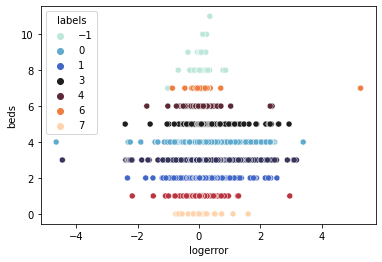

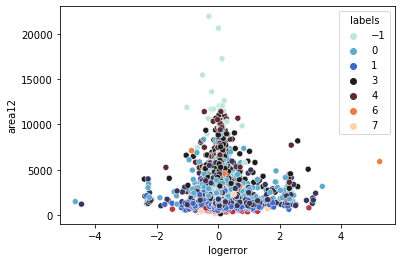

In [41]:
sns.scatterplot(df.logerror, df.beds, hue=df.labels, palette='icefire')
plt.show()

sns.scatterplot(df.logerror, df.area12, hue=df.labels, palette='icefire')
plt.show()

Text(0.5, 0, 'area12')

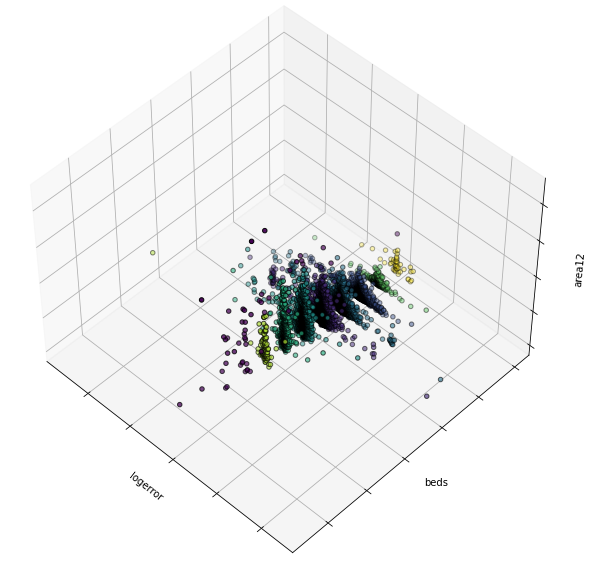

In [42]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.logerror, df.beds, df.area12,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('logerror')
ax.set_ylabel('beds')
ax.set_zlabel('area12')